In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


from tqdm.notebook import trange
import einops 
import matplotlib.pyplot as plt 

from dataclasses import dataclass, replace
import seaborn as sns

In [3]:
@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int

class Model(nn.Module):
    def __init__(self,
                config,
                feature_sparsity=None,
                feature_importance=None):
        super().__init__()

        self.config = config
        self.W = nn.Parameter(torch.empty([config.n_instances, config.n_features, config.n_hidden]))
        nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.zeros([config.n_instances, config.n_features]))
        
        if feature_sparsity is None:
            self.feature_sparsity = torch.ones(())
        else:
            self.feature_sparsity = feature_sparsity
        
        if feature_importance is None:
            self.feature_importance = torch.ones(())
        else:
            self.feature_importance = feature_importance

    def forward(self, X):
        h = torch.einsum("...if,ifh -> ...ih", X, self.W)
        out = torch.einsum("...ih,ifh -> ...if", h, self.W)
        out = F.relu(out + self.b)
        return out

    def generate_batch(self, batch_size):
        batch_dims = [batch_size, self.config.n_instances, self.config.n_features]
        batch = torch.rand(batch_dims)
        return torch.where(torch.rand(batch_dims) <= self.feature_sparsity,
                            batch,
                              0)

In [4]:
@dataclass
class Config2:
    n_features: int
    n_hidden1: int
    n_hidden2: int
    n_instances: int

class AutoEncoder2(nn.Module):
    def __init__(self,
                 config,
                 importance=None,
                 sparsity=None):
        super().__init__()

        self.W1 = nn.Parameter(torch.empty([config.n_instances, config.n_features, config.n_hidden1]))
        self.b1 = nn.Parameter(torch.zeros([config.n_instances, config.n_features]))
        
        self.W2 = nn.Parameter(torch.empty([config.n_instances, config.n_hidden1, config.n_hidden2]))
        self.b2 = nn.Parameter(torch.zeros([config.n_instances, config.n_features]))

        nn.init.xavier_normal_(self.W1)
        nn.init.xavier_normal_(self.W2)

        self.sparsity = sparsity
        if sparsity is None: 
            self.sparsity = torch.ones(())

        self.importance = importance
        if importance is None: 
            self.importance = torch.ones(())
    
    def forward(self, X):
        "X in [n_batch, n_instance, n_features]"
        h1 = torch.einsum("...if, ifh -> ...ih", X, self.W1) + self.b1
        h2 = torch.einsum("...ih, ihy, -> ...iy", h1, self.W2) + self.b2
        o = torch.einsum("...ih, ifh -> ...if", h2, self.W1) 
        o = F.relu(o)
        return o

config = Config2(n_features=10, n_hidden1=3, n_hidden2=3, n_instances=10)
m2 = AutoEncoder2(config=config)

In [5]:
def constant_lr(*_):
  return 1.0

def optimize(model,
             batch_size=1024,
             steps=10000,
             lr=1e-3,
             hook_freq = 10
             ):
    cfg = model.config
    opt = torch.optim.AdamW(list(model.parameters()), lr=lr)
    
    n_hooks = int(steps/hook_freq)
    losses = np.empty([n_hooks, cfg.n_instances, cfg.n_features])
    weights = np.empty([n_hooks, cfg.n_instances, cfg.n_features, cfg.n_hidden])

    for step in trange(steps):
       opt.zero_grad(set_to_none=True)
       X = model.generate_batch(batch_size)
       X_pred = model(X)
       error = model.feature_importance*torch.pow(X - X_pred, 2)
       # batch error
       loss = einops.reduce(error, "b i f -> i", "mean").sum()
       # backpropagate + update newtork
       loss.backward()
       opt.step()
       if step % hook_freq == 0:
        
        losses[int(step/hook_freq)] = einops.reduce(error, "b i f -> i f", "mean").detach().numpy()
        weights[int(step/hook_freq), ...] = model.W.detach().numpy().copy()


    return dict(losses=losses, weights=weights)

cfg = Config(n_features=9, n_hidden=3, n_instances=2)
#importance = (0.9**torch.arange(cfg.n_features))
importance = torch.tensor([0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9])
#feature_sparsity = (20 ** -torch.linspace(0, 1, cfg.n_instances))[:, None]
feature_sparsity = torch.ones([cfg.n_instances])[:, None]*0.2
m = Model(cfg, 
          feature_sparsity=0.2,
          feature_importance=importance)

l = optimize(m, steps=20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

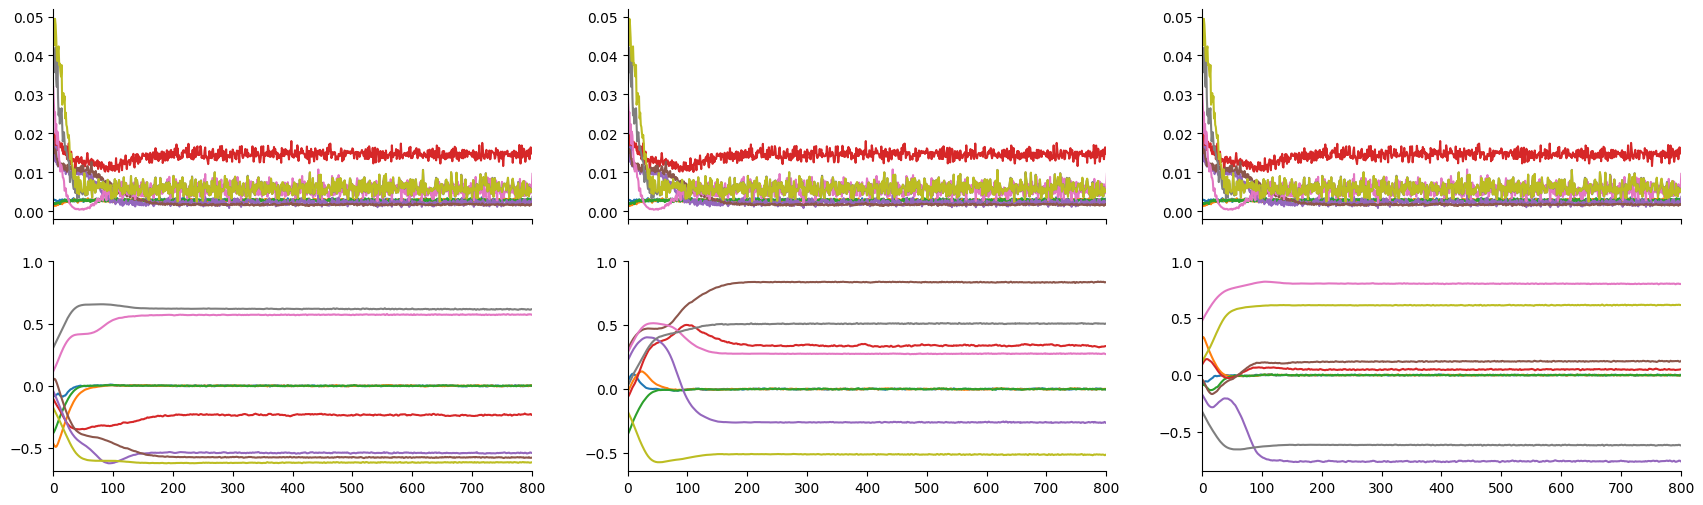

In [6]:
fig, ax = plt.subplots(2, cfg.n_hidden, height_ratios=(1, 1), figsize=(21, 6), sharex=True)
instance = 0

for hidden in range(cfg.n_hidden):
    for feature in range(cfg.n_features):
        ax[0, hidden].plot(l["losses"][:, instance, feature])
        ax[1, hidden].plot(l["weights"][:, instance, feature, hidden])

    ax[1, hidden].set_yticks([-0.5, 0, 0.5, 1])
ax[1, 0].set_xlim([0, 800])
sns.despine()


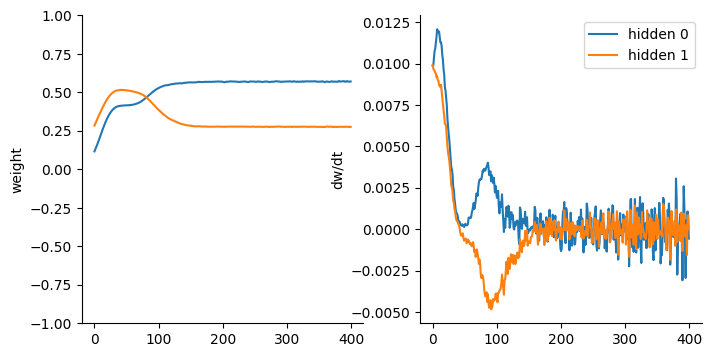

In [ ]:
instance = 0
feature = 6

dw = np.diff(l["weights"][:, instance, feature, :], axis=0)
w = l["weights"][:, instance, feature, :]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
epoch = np.arange(0, 400)
for i in range(2):
    ax[0].plot(epoch, w[epoch, i])
    ax[1].plot(epoch, dw[epoch, i], label=f"hidden {i}")
ax[1].legend()
ax[0].set_ylim([-1, 1])
ax[0].set_ylabel("weight")
ax[1].set_ylabel("dw/dt")
sns.despine()

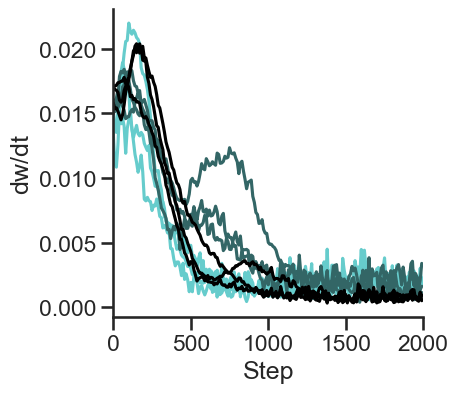

In [27]:
sns.set(style="ticks", context="talk")
dw = np.abs(np.diff(l["weights"], axis=0))**2
fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True)

epoch = np.arange(0, 200)
cs = [i*np.array([0.5, 1, 1]) for i in [0.8, 0.4, 0]]

for feature in range(cfg.n_features):
    ax_i = feature // 3
    y = np.sqrt(dw[:, :, feature, :].sum(axis=2)).mean(axis=1)
    ax.plot(epoch, y[epoch], c=cs[ax_i])
#ax.legend()
ax.set_ylabel("dw/dt")
ax.set_xlim([0, 200])
ax.set_xticks([0, 50, 100, 150, 200], labels=[0, 500, 1000, 1500, 2000])
ax.set_xlabel("Step")
sns.despine()

(-1.1, 1.1)

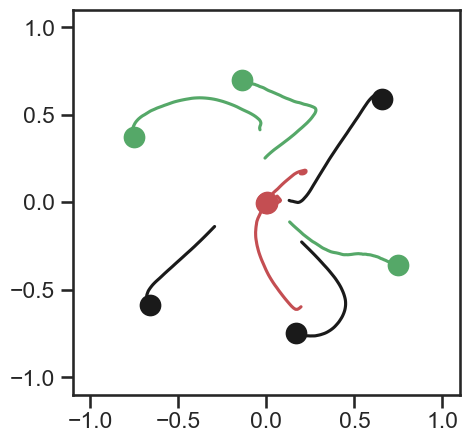

In [28]:
instance = 1

representations = l["weights"][:, instance, :, :]
fig, ax = plt.subplots(1,  figsize=(5, 5))
t = np.arange(0, 100)
alpha= 1
s = np.linspace(0, 50, len(t))
s = 200
for _feature in [0, 1, 2]:
    rep = representations[t, ...][:, _feature, [0, 1]]
    ax.plot(rep[:, 0], rep[:, 1], c="r")
    ax.scatter(rep[-1, 0], rep[-1, 1], s=s, alpha=alpha, c="r")


for _feature in [3, 4, 5]:
    rep = representations[t, ...][:, _feature, [0, 1]]
    ax.plot(rep[:, 0], rep[:, 1], c="g")
    ax.scatter(rep[-1, 0], rep[-1, 1], s=s, alpha=alpha, c="g")


for _feature in [6, 7, 8]:
    rep = representations[t, ...][:, _feature, [0, 1]]
    ax.plot(rep[:, 0], rep[:, 1], c="k")
    ax.scatter(rep[-1, 0], rep[-1, 1], s=s, alpha=alpha, c="k")

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])